# CountMin vs Count Sketch

### Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from math import log, ceil, e, sqrt
import random

In [2]:
def pairwise_hash(a, b, prime, x):
    return (a * x + b) % prime

### CountMin Sketch

In [3]:
class CountMinSketch:
    def __init__(self, epsilon, delta):
        self.w = ceil(4 /(epsilon * epsilon))
        self.d = ceil(4*log(1 / delta))
        self.table = np.zeros((self.d, self.w), dtype=int)
        self.prime = 2147483647
        # Random coefficients for pairwise independent hash functions
        self.hash_params = [(random.randint(1, self.prime - 1), random.randint(0, self.prime - 1)) for _ in range(self.d)]

    def update(self, x, count=1):
        for i, (a, b) in enumerate(self.hash_params):
            idx = pairwise_hash(a, b, self.prime, x) % self.w
            self.table[i][idx] += count

    def estimate(self, x):
        estimates = []
        for i, (a, b) in enumerate(self.hash_params):
            idx = pairwise_hash(a, b, self.prime, x) % self.w
            estimates.append(self.table[i][idx])
        return min(estimates)

### Count Sketch

In [4]:
# CountSketch class
class CountSketch:
    def __init__(self, epsilon, delta):
        self.w = ceil(4 / (epsilon * epsilon))
        self.d = ceil(4 * log(1 / delta))
        self.table = np.zeros((self.d, self.w), dtype=int)
        self.prime = 2147483647
        # Random coefficients for pairwise independent hash functions
        self.hash_params = [(random.randint(1, self.prime - 1), random.randint(0, self.prime - 1)) for _ in range(self.d)]
        # Random sign function
        self.signs = [random.choice([-1, 1]) for _ in range(self.d)]

    def update(self, x, count=1):
        for i, (a, b) in enumerate(self.hash_params):
            idx = pairwise_hash(a, b, self.prime, x) % self.w
            sign = self.signs[i]
            self.table[i][idx] += sign*count

    def estimate(self, x):
        estimates = []
        for i, (a, b) in enumerate(self.hash_params):
            idx = pairwise_hash(a, b, self.prime, x) % self.w
            sign = self.signs[i]
            estimates.append(sign * self.table[i][idx])
        return np.median(estimates)

### Generate Stream and Metric Definition

In [5]:
def generate_stream(n, m, maxVal):
    return [(random.randint(1, n), random.randint(1, maxVal)) for _ in range(m)]

def calculate_mae(actual, estimates):
    return np.mean([abs(actual[i] - estimates[i]) for i in range(len(actual))])

def calculate_mre(actual, estimates):
    return np.mean([abs(actual[i] - estimates[i]) / actual[i] if actual[i] != 0 else 0 for i in range(len(actual))])

### Compare Method

In [6]:
def compare_sketches(n, m, epsilon, delta, K, maxVal=1):
    stream = generate_stream(n, m, maxVal)

    # Exact counts
    exact_counts = defaultdict(int)
    for elem in stream:
        exact_counts[elem[0]] += elem[1]

    # Initialize sketches
    cms = CountMinSketch(epsilon, delta)
    cs = CountSketch(epsilon, delta)

    # Prepare lists to store metrics for dynamic plotting
    items_processed = []
    cms_mae, cms_mre = [], []
    cs_mae, cs_mre = [], []

    # Update sketches and compute metrics after each K items
    for i, elem in enumerate(stream):
        cms.update(elem[0], elem[1])
        cs.update(elem[0], elem[1])

        # Calculate metrics after every K items
        if (i + 1) % K == 0:
            cms_estimates = [cms.estimate(x) for x in range(1, n + 1)]
            cs_estimates = [cs.estimate(x) for x in range(1, n + 1)]
            actual_frequencies = [exact_counts[x] for x in range(1, n + 1)]
            
            # Append metrics for CountMin Sketch
            cms_mae.append(calculate_mae(actual_frequencies, cms_estimates))
            cms_mre.append(calculate_mre(actual_frequencies, cms_estimates))

            # Append metrics for CountSketch
            cs_mae.append(calculate_mae(actual_frequencies, cs_estimates))
            cs_mre.append(calculate_mre(actual_frequencies, cs_estimates))

            items_processed.append(i + 1)

    # Plotting the metrics over the number of processed items
    plt.figure(figsize=(15, 13))

    # MAE Plot
    plt.subplot(2, 1, 1)
    plt.plot(items_processed, cms_mae, label='CountMin MAE', color='red', linestyle='dotted', marker='x')
    plt.plot(items_processed, cs_mae, label='CountSketch MAE', color='green', linestyle='dotted', marker='s')
    plt.xlabel('Items Processed')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()
    plt.title('Mean Absolute Error of CountMin and CountSketch Over Stream Processing')

    # MRE Plot
    plt.subplot(2, 1, 2)
    plt.plot(items_processed, cms_mre, label='CountMin MRE', color='red', linestyle='dotted', marker='x')
    plt.plot(items_processed, cs_mre, label='CountSketch MRE', color='green', linestyle='dotted', marker='s')
    plt.xlabel('Items Processed')
    plt.ylabel('Mean Relative Error (MRE)')
    plt.legend()
    plt.title('Mean Relative Error of CountMin and CountSketch Over Stream Processing')

    plt.tight_layout()
    plt.show()

    # Final metric calculations
    final_cms_mae = calculate_mae(actual_frequencies, cms_estimates)
    final_cs_mae = calculate_mae(actual_frequencies, cs_estimates)
    final_cms_mre = calculate_mre(actual_frequencies, cms_estimates)
    final_cs_mre = calculate_mre(actual_frequencies, cs_estimates)

    print(f"CountMin Sketch final MAE: {final_cms_mae}")
    print(f"Count Sketch final MAE: {final_cs_mae}")
    print(f"CountMin Sketch final MRE: {final_cms_mre}")
    print(f"Count Sketch final MRE: {final_cs_mre}")

In [7]:
def calculateMatrixSize(delta, epsilon):
        print('Total Size = ', ceil(4 / (epsilon * epsilon)) * ceil(4 * log(1 / delta)), ', d = ', ceil(4 * log(1 / delta)), ', w = ', ceil(4 / (epsilon * epsilon)))  

### Result for size = 4000 

Total Size =  4000 , d =  10 , w =  400


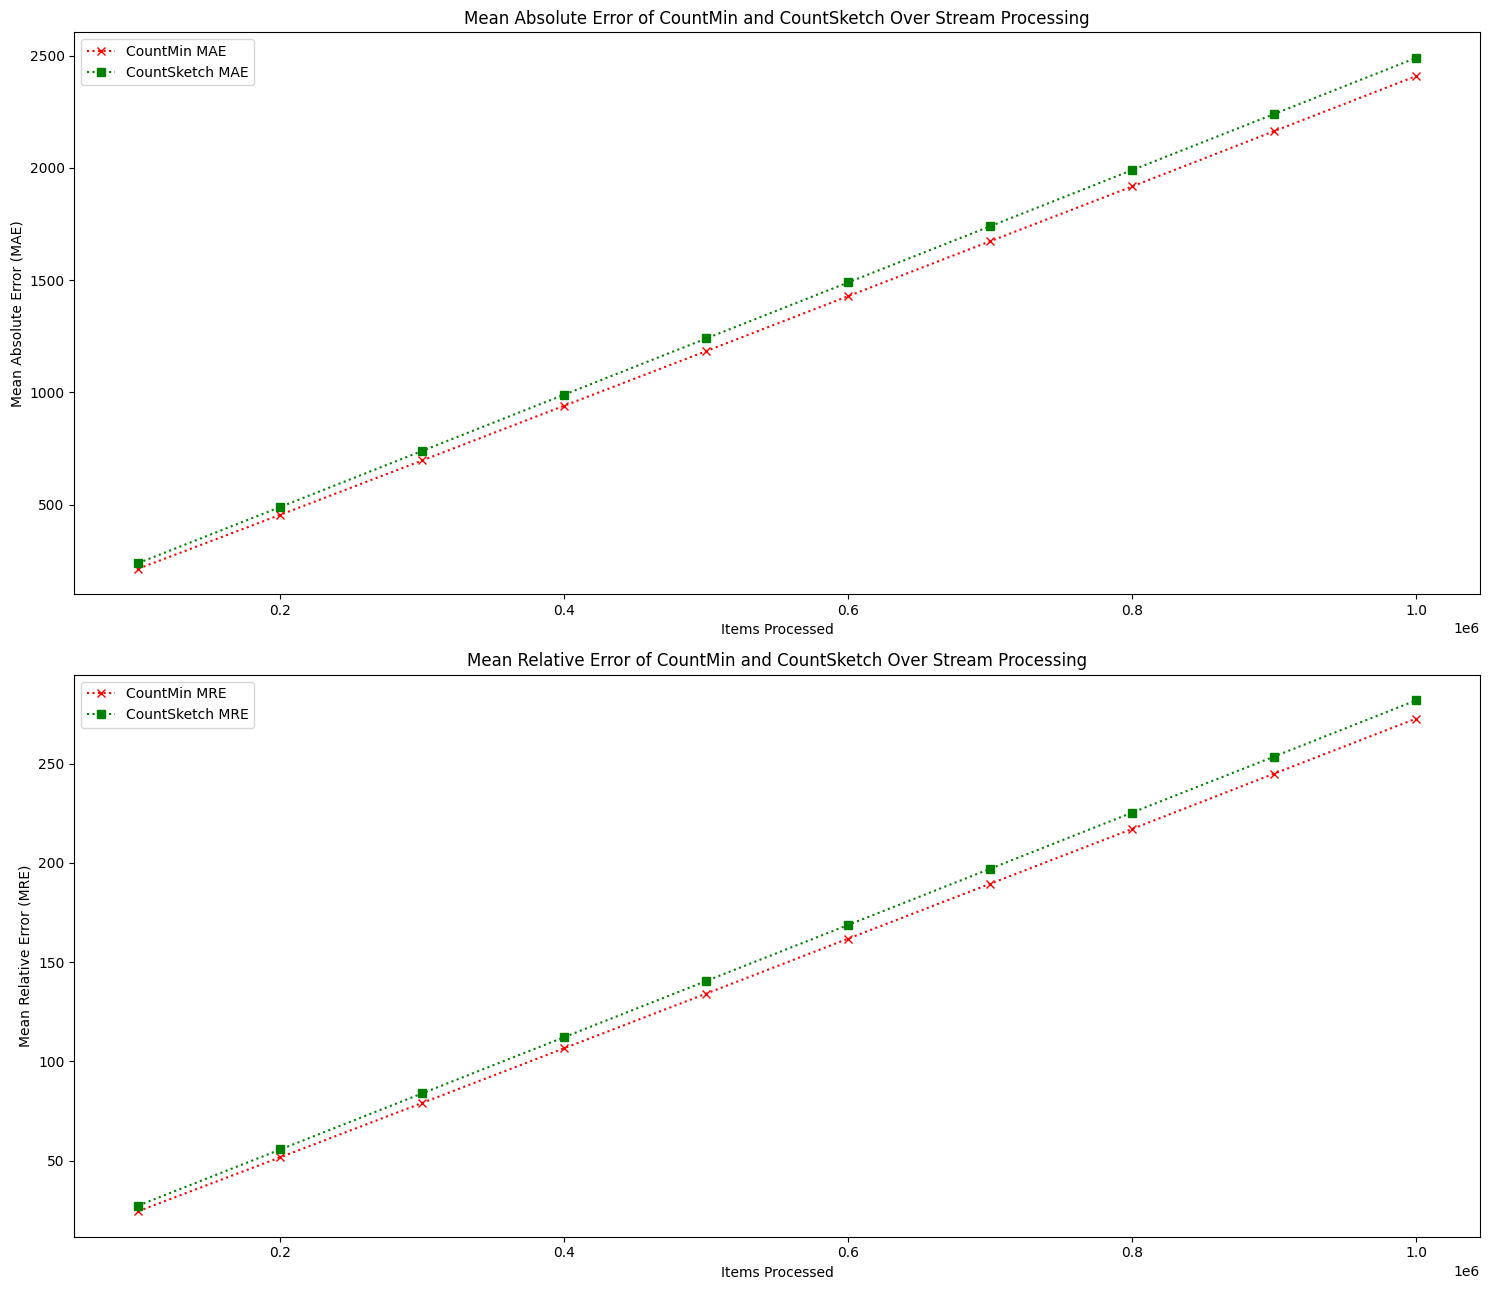

CountMin Sketch final MAE: 2409.13525
Count Sketch final MAE: 2490.246025
CountMin Sketch final MRE: 272.7255684417305
Count Sketch final MRE: 281.90654515351906


In [8]:
# Example configuration
n = 10**5  # Number of distinct elements
m = 10**6  # Length of the stream
delta = 0.1
epsilon = 0.1
k = 10**5
maxVal = 1
calculateMatrixSize(delta, epsilon)
compare_sketches(n, m, epsilon, delta, k, maxVal)

### Result for Size = 30,400

Total Size =  30400 , d =  19 , w =  1600


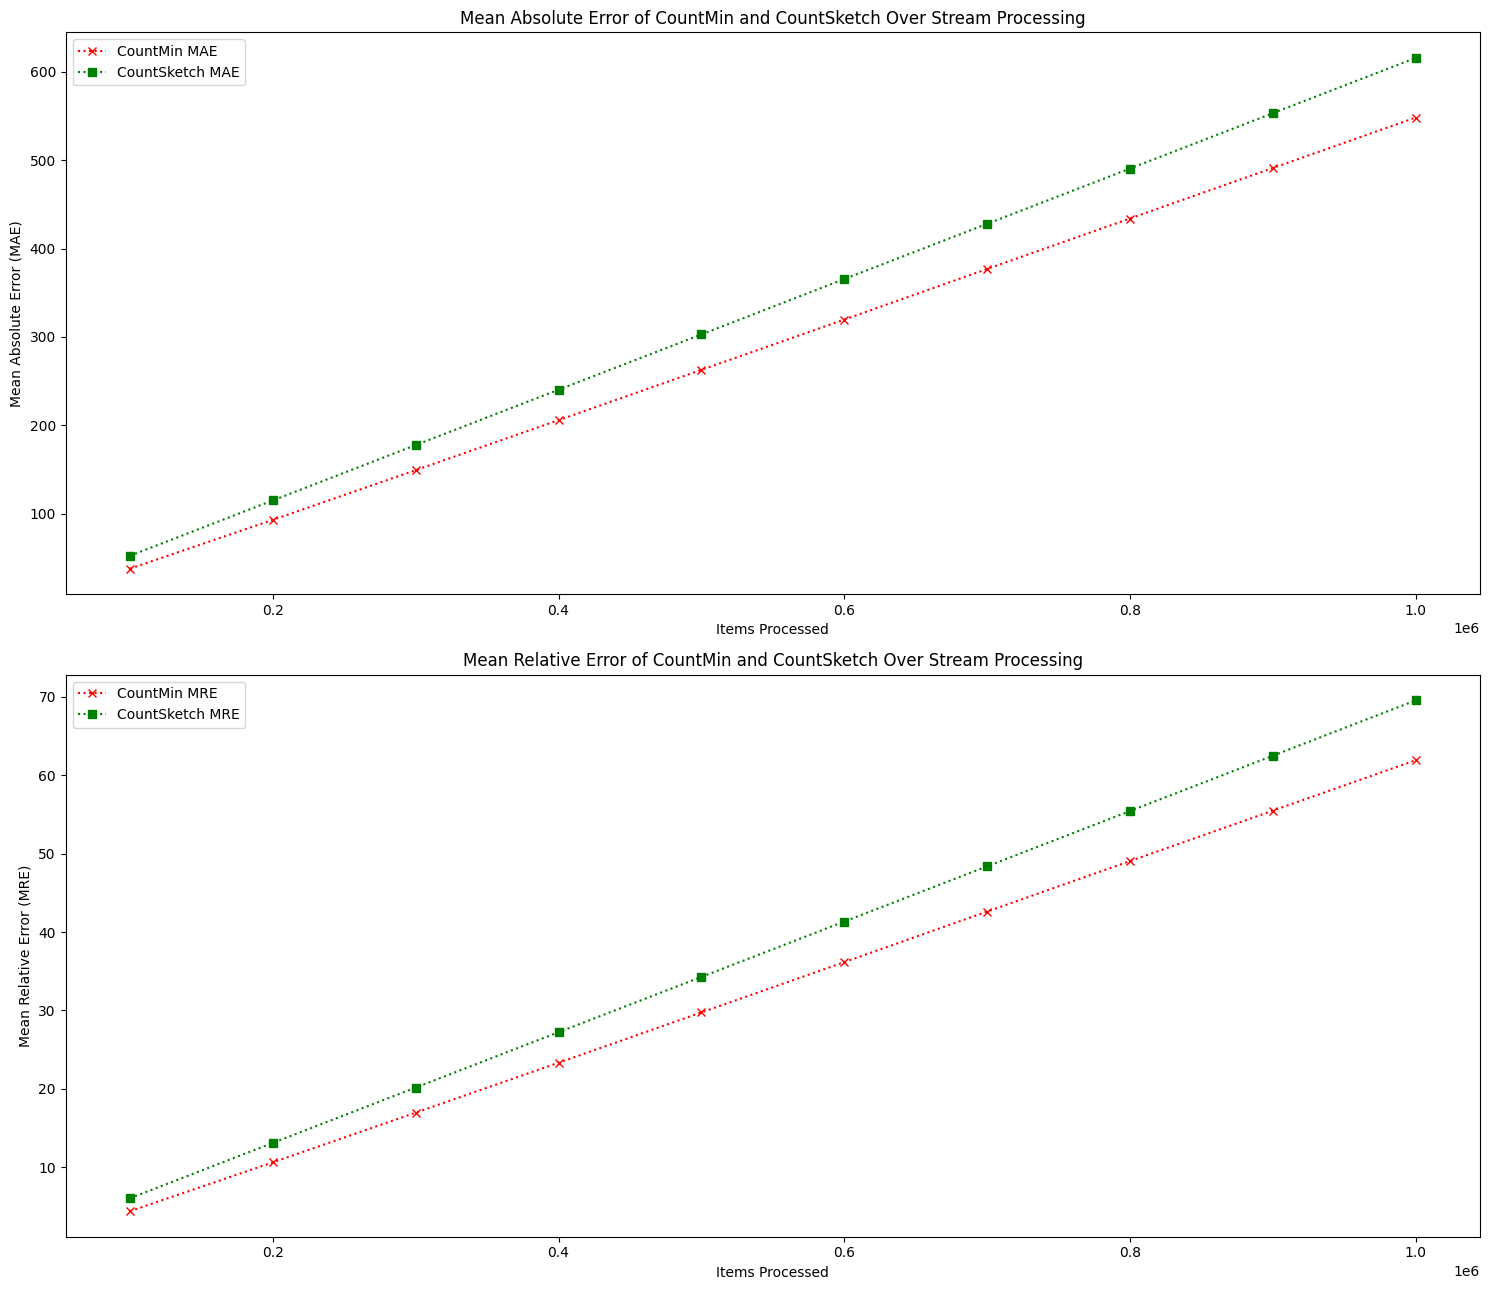

CountMin Sketch final MAE: 548.10082
Count Sketch final MAE: 615.61091
CountMin Sketch final MRE: 61.90387703444206
Count Sketch final MRE: 69.53257479195763


In [9]:
# Example configuration
n = 10**5  # Number of distinct elements
m = 10**6  # Length of the stream
delta = 0.01
epsilon = 0.05
k = 10**5
maxVal = 1
calculateMatrixSize(delta, epsilon)
compare_sketches(n, m, epsilon, delta, k, maxVal)

## Result for Large Size

Total Size =  112000000 , d =  28 , w =  4000000


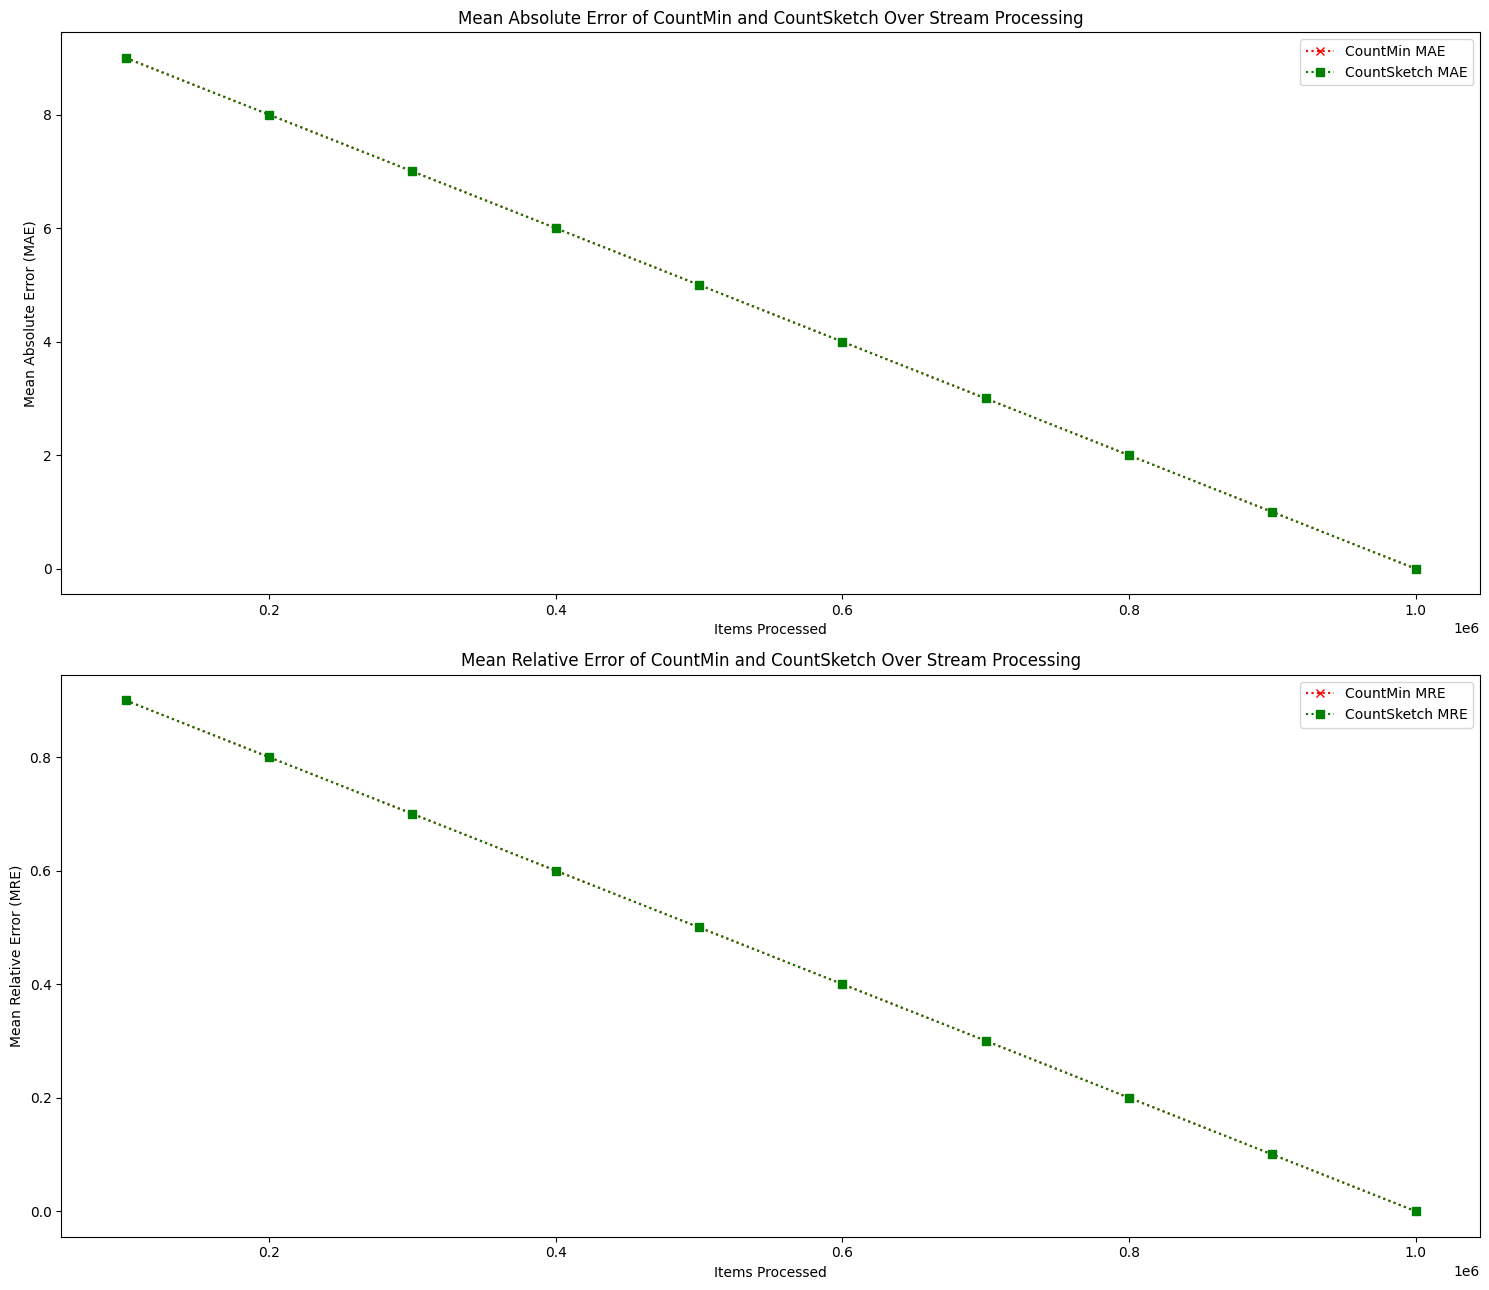

CountMin Sketch final MAE: 0.0
Count Sketch final MAE: 0.0
CountMin Sketch final MRE: 0.0
Count Sketch final MRE: 0.0


In [10]:
# Example configuration
n = 10**5  # Number of distinct elements
m = 10**6  # Length of the stream
delta = 0.001
epsilon = 0.001
k = 10**5
maxVal = 1
calculateMatrixSize(delta, epsilon)
compare_sketches(n, m, epsilon, delta, k, maxVal)

### Count != 1

### Result for size = 4000

Total Size =  4000 , d =  10 , w =  400


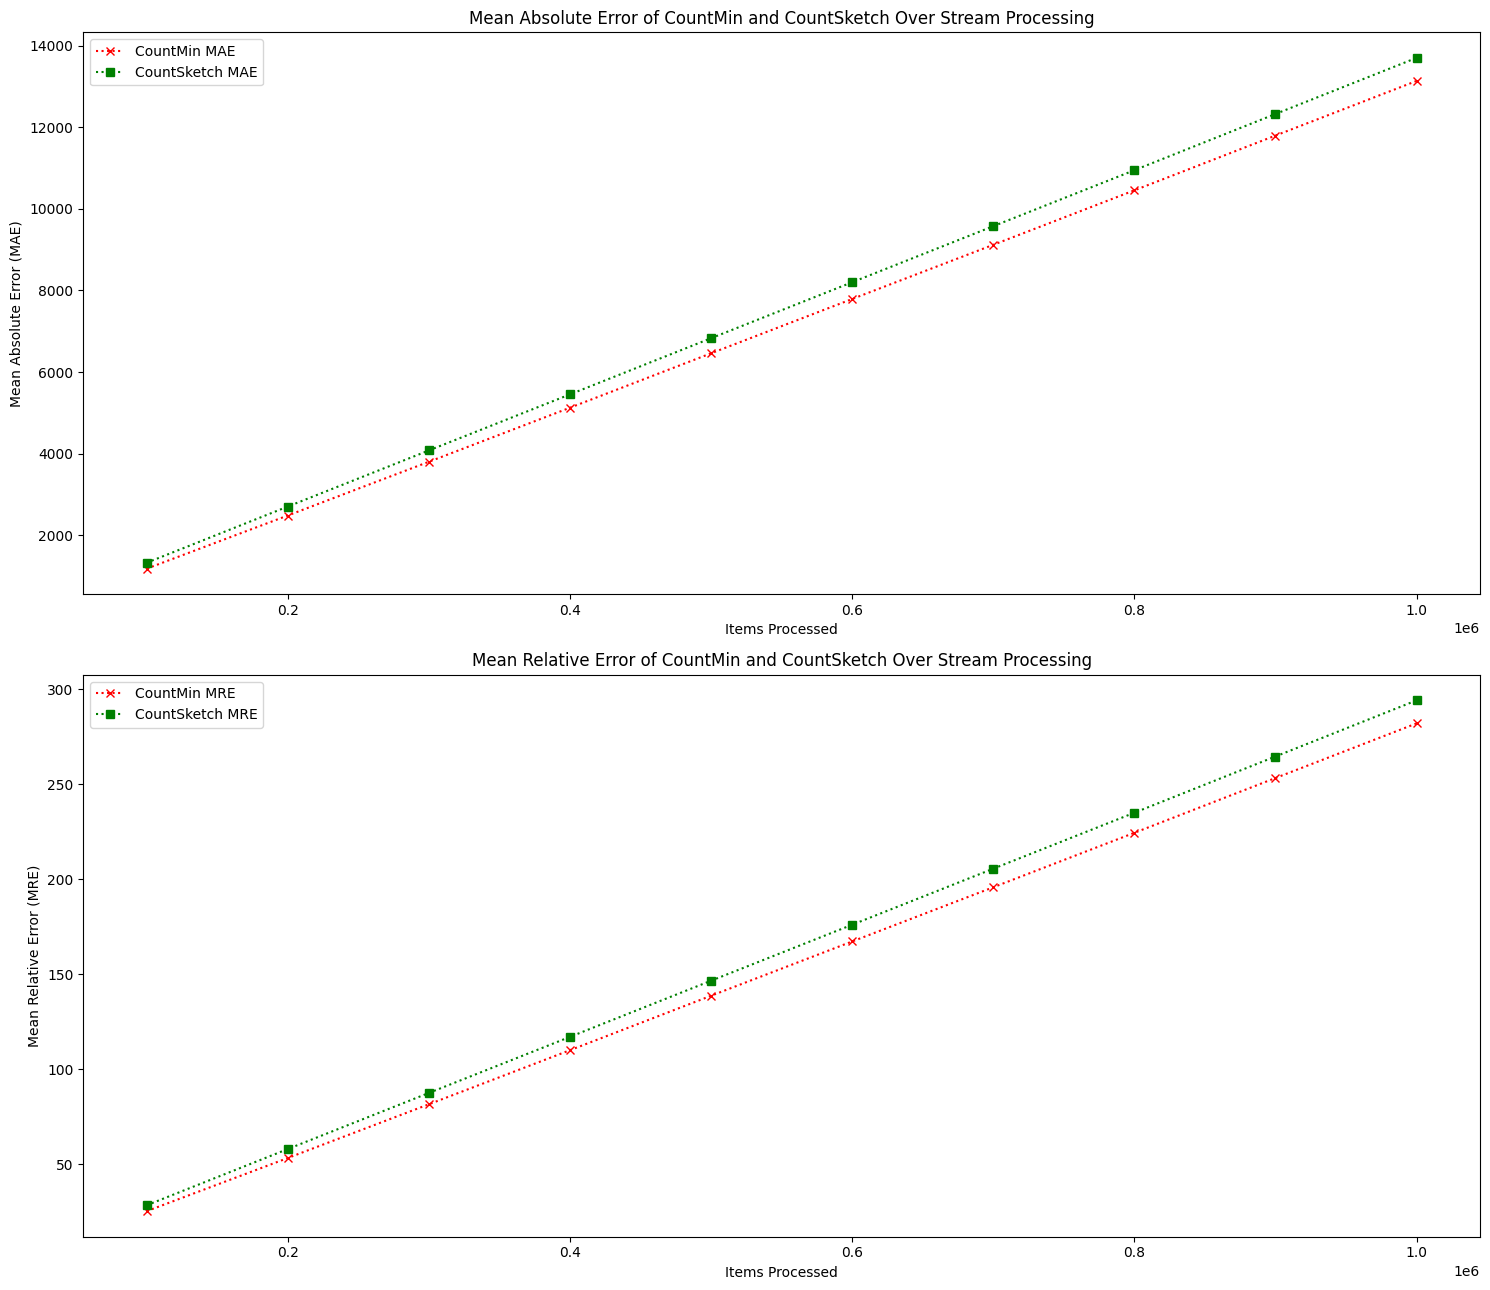

CountMin Sketch final MAE: 13137.49667
Count Sketch final MAE: 13703.96047
CountMin Sketch final MRE: 281.9800839360065
Count Sketch final MRE: 294.10729308311795


In [11]:
# Example configuration
n = 10**5  # Number of distinct elements
m = 10**6  # Length of the stream
delta = 0.1
epsilon = 0.1
k = 10**5
maxVal = 10
calculateMatrixSize(delta, epsilon)
compare_sketches(n, m, epsilon, delta, k, maxVal)

### Result for size = 30,400

Total Size =  30400 , d =  19 , w =  1600


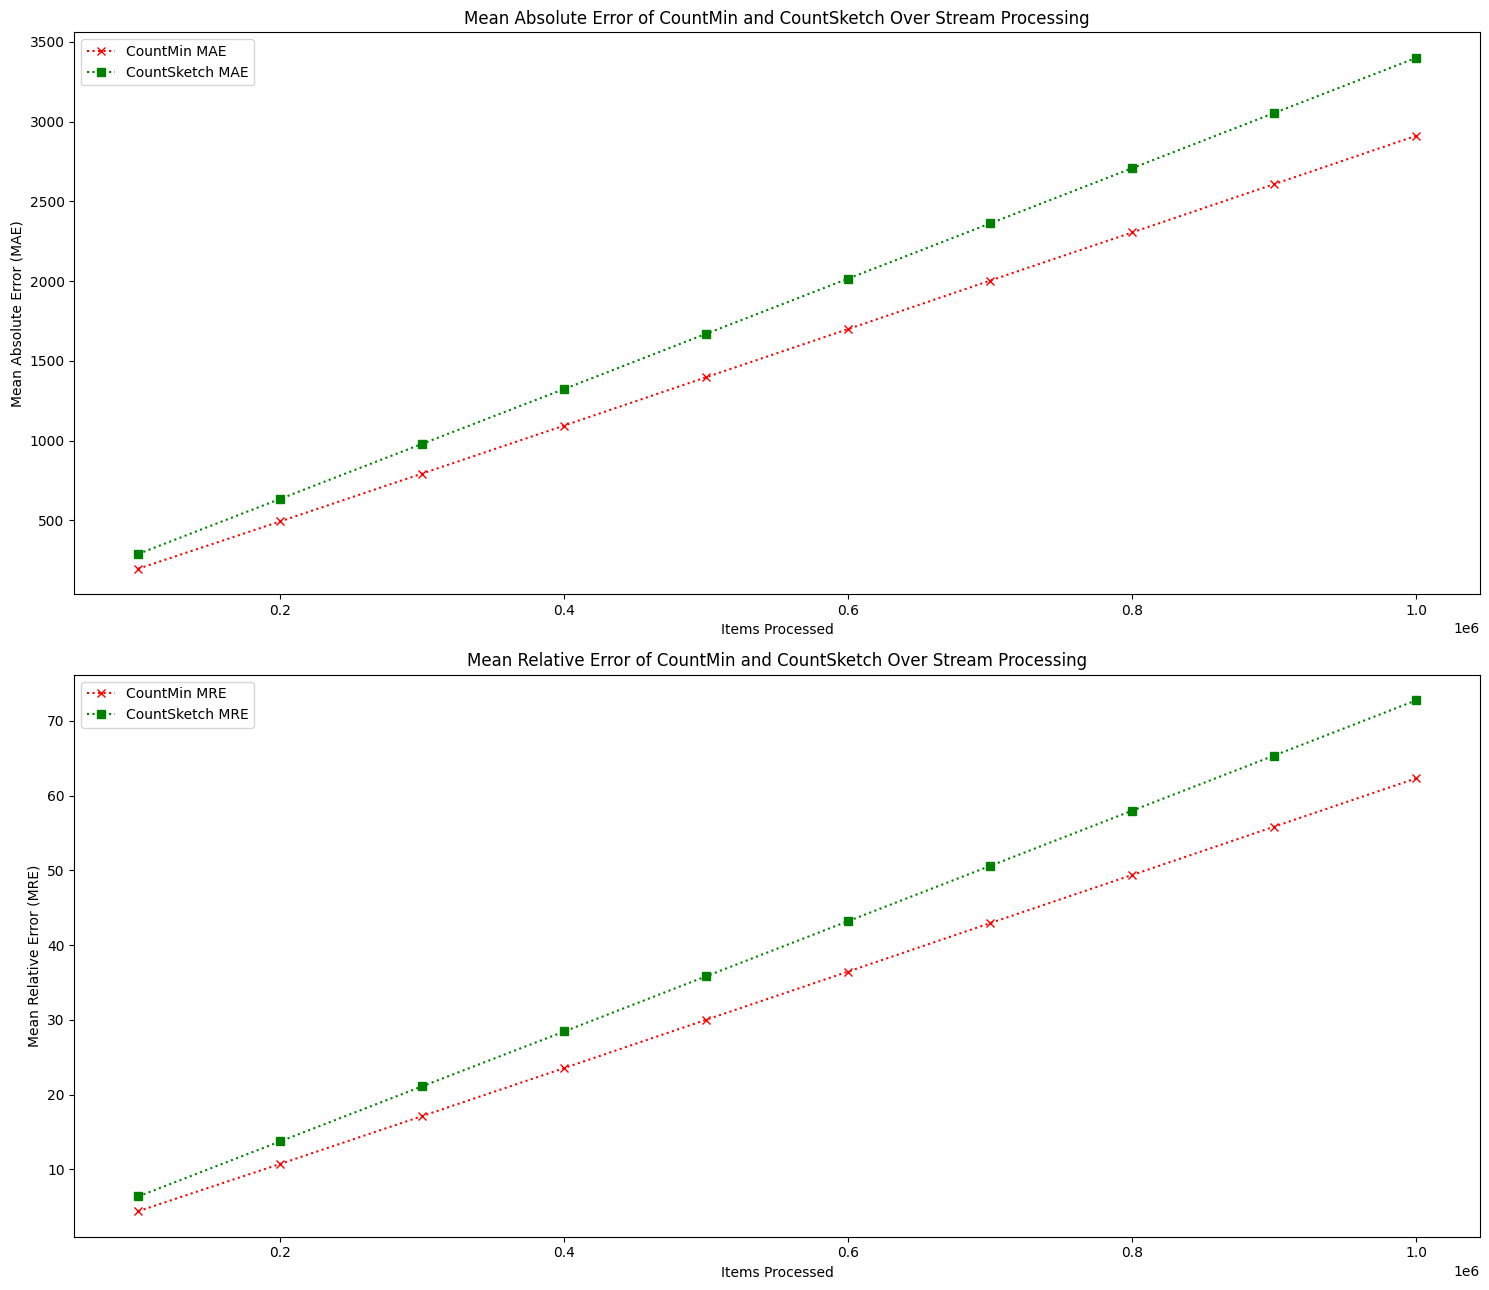

CountMin Sketch final MAE: 2910.72281
Count Sketch final MAE: 3398.93616
CountMin Sketch final MRE: 62.316255802931025
Count Sketch final MRE: 72.74967383344587


In [12]:
# Example configuration
n = 10**5  # Number of distinct elements
m = 10**6  # Length of the stream
delta = 0.01
epsilon = 0.05
k = 10**5
maxVal = 10
calculateMatrixSize(delta, epsilon)
compare_sketches(n, m, epsilon, delta, k, maxVal)

### Result for large size

Total Size =  112000000 , d =  28 , w =  4000000


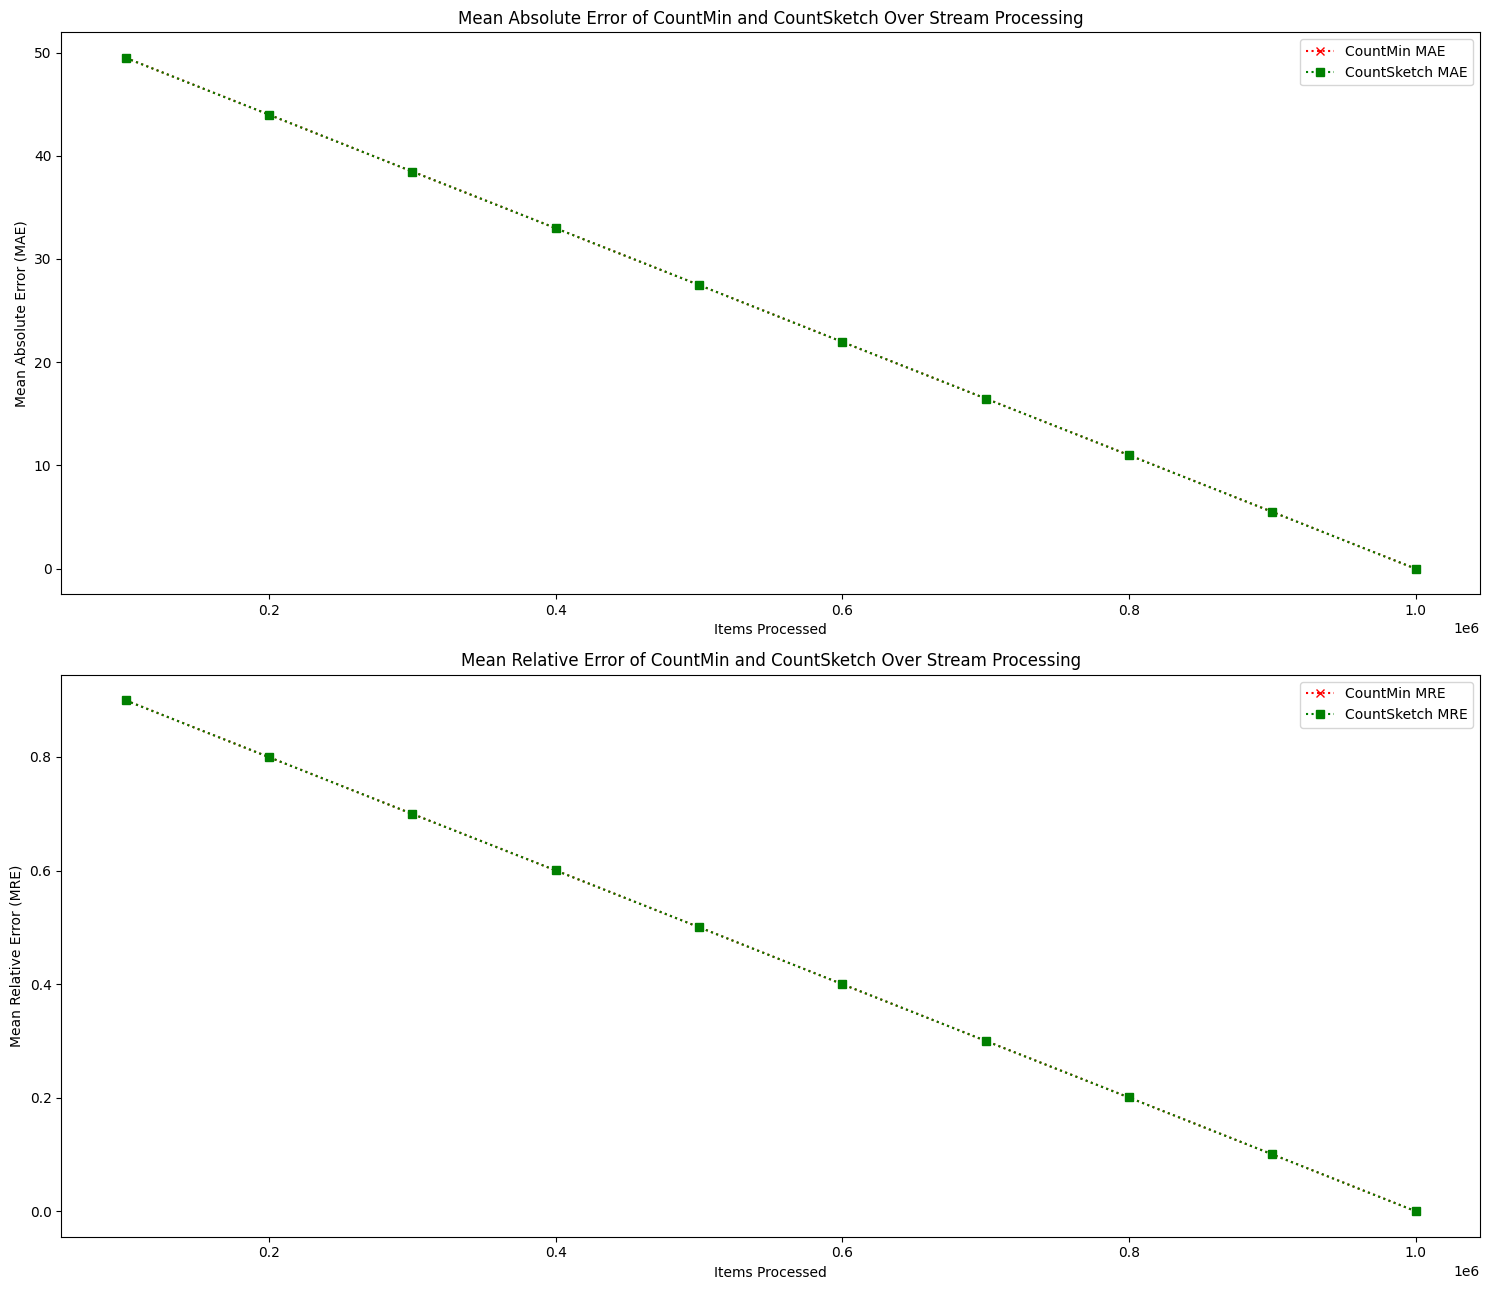

CountMin Sketch final MAE: 0.0
Count Sketch final MAE: 0.0
CountMin Sketch final MRE: 0.0
Count Sketch final MRE: 0.0


In [13]:
# Example configuration
n = 10**5  # Number of distinct elements
m = 10**6  # Length of the stream
delta = 0.001
epsilon = 0.001
k = 10**5
maxVal = 10
calculateMatrixSize(delta, epsilon)
compare_sketches(n, m, epsilon, delta, k, maxVal)

### Print table for n = 20

In [27]:
def compare_sketches_with_table(n, m, epsilon, delta, K):
    stream = generate_stream(n, m, 1)

    # Exact counts
    exact_counts = defaultdict(int)
    for elem in stream:
        exact_counts[elem[0]] += elem[1]

    # Initialize sketches
    cms = CountMinSketch(epsilon, delta)
    cs = CountSketch(epsilon, delta)

    # Update sketches with stream
    for elem in stream:
        cms.update(elem[0], elem[1])
        cs.update(elem[0], elem[1])

    # Compute final estimates for CountMin and CountSketch
    cms_estimates = [cms.estimate(x) for x in range(1, n + 1)]
    cs_estimates = [int(cs.estimate(x)) for x in range(1, n + 1)]
    actual_frequencies = [exact_counts[x] for x in range(1, n + 1)]

    # Print table of actual and estimated values
    print(f"{'Element':<10}{'Actual':<10}{'CountMin':<15}{'CountSketch':<15}")
    print("-" * 50)
    for i in range(n):
        print(f"{i + 1:<10}{actual_frequencies[i]:<10}{cms_estimates[i]:<15}{cs_estimates[i]:<15}")

# Example usage for n = 20
compare_sketches_with_table(n=20, m=1000, epsilon=0.5, delta=0.5, K=10)

Element   Actual    CountMin       CountSketch    
--------------------------------------------------
1         47        89             93             
2         53        53             53             
3         53        53             53             
4         51        88             51             
5         54        54             96             
6         42        89             91             
7         53        94             53             
8         65        65             65             
9         58        58             103            
10        53        53             106            
11        45        45             45             
12        57        57             57             
13        49        49             49             
14        46        46             93             
15        51        51             104            
16        45        90             45             
17        37        37             37             
18        52        52         